# Assignment 1

In [65]:
import sys
import nltk
import math
import itertools
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

## Daten einlesen

In [7]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

## Hilfsfunktionen

In [8]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [9]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Häufigkeitsverteilungen

In [165]:
def get_letters() -> [str]:
    return [chr(i) for i in range(ord('a'), ord('z')+1)]


def get_chars(text: str) -> [str]:
    return [char.lower() for char in text if char.lower() in get_letters()]


def character_distribution(people: [str]) -> (np.ndarray, np.ndarray, np.ndarray):    
    mean = np.zeros(shape = 26)
    std = np.zeros(shape = 26)
    dist = np.ones(shape = (len(people), 26))
        
    # TODO        
    k = 0
    for text in people:
        chars = get_chars(text)
        charCount = len(chars)
        fdist = nltk.FreqDist(chars)
                    
        for i, c in enumerate(get_letters()):
            dist[k, i] = fdist[c] / charCount
        k = k + 1
        
    for i in range(0, 26):
        std[i] = dist[:, i].std()
        mean[i] = dist[:, i].mean()
    
    return mean, std, dist


def character_distribution_nn(people: [str]) -> np.ndarray:
    x = np.zeros(shape=(2, len(people)))
    
    for k, text in enumerate(people):
        chars = get_chars(text)
        fdist = nltk.FreqDist(chars)
        dist = np.zeros(shape=26)
                    
        for i, c in enumerate(get_letters()):
            dist[i] = fdist.freq(c)
        
        x[0, k] = dist.mean()
        x[1, k] = dist.std()
    return x

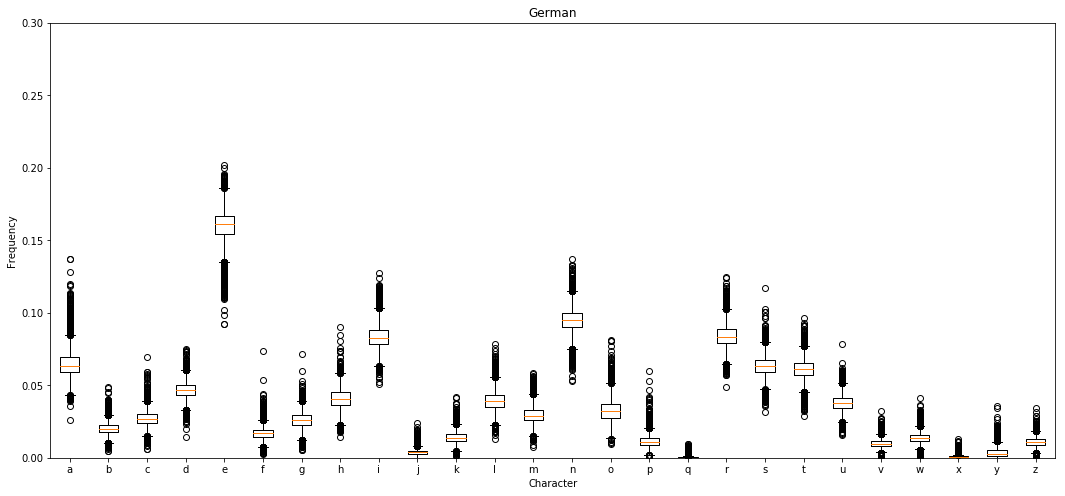

In [12]:
mean_de, std_de, dist_de = character_distribution(people_de['text'])
box_plot(dist_de, 'German')

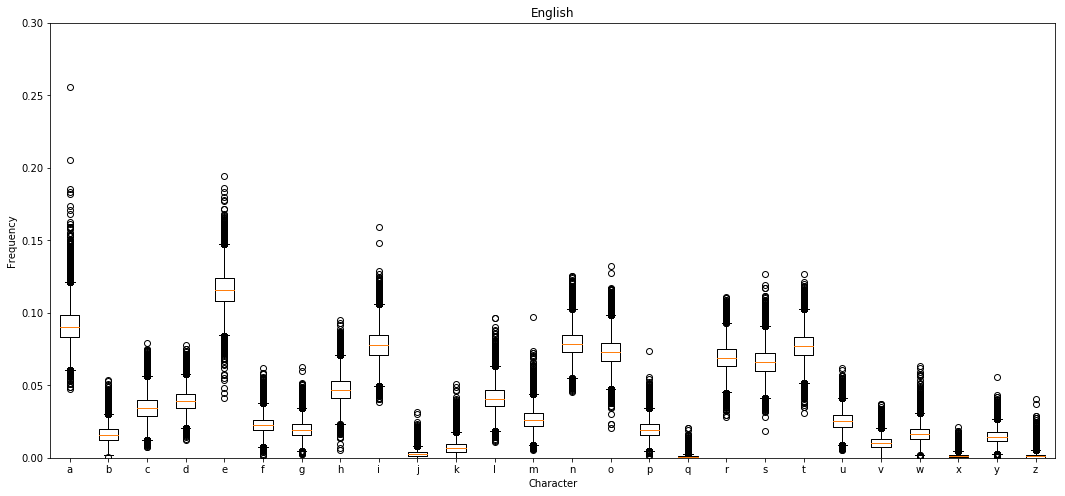

In [13]:
mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

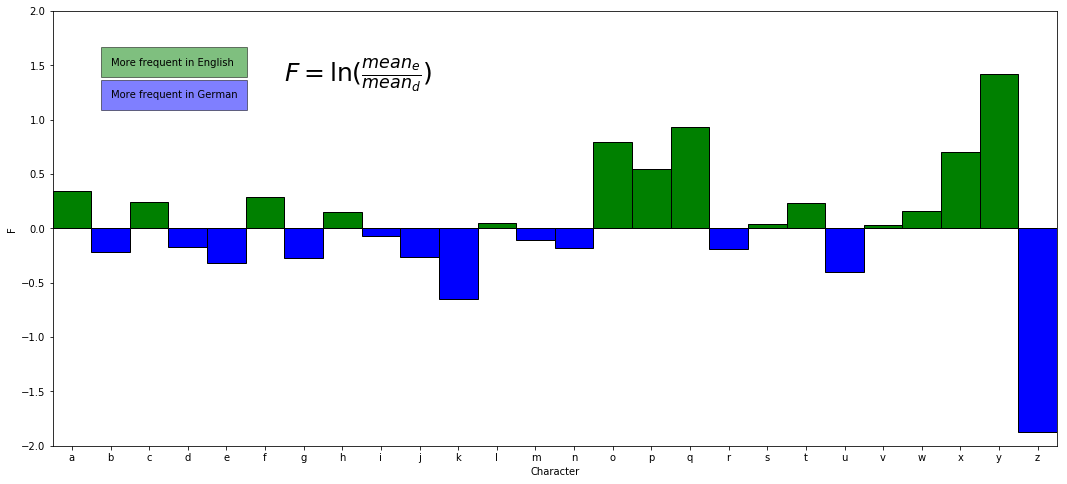

In [14]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

In [148]:
def calc_p(mean: np.ndarray, std: np.ndarray, dist: np.ndarray) -> float:
    # mean = 2
    # std = 1
    # dist = 3
    # p = 1/2 * (np.abs(mean - dist) - std) - 1
    p = np.abs(mean - dist) < std
    #p = p * dist
    # p = np.abs(mean - dist) < std
    return p.sum() / p.shape[0]


def calc_p2(mean: np.ndarray, std: np.ndarray, dist: np.ndarray) -> float:
    p = np.log(stats.norm.pdf(dist, mean, std))
    return p.sum()


def determine_language(
        mean_de: np.ndarray, 
        std_de: np.ndarray, 
        mean_en: np.ndarray, 
        std_en: np.ndarray, 
        texts: [str],
        epsilon: float) -> [str]:
    # Implementieren Sie eine Funktion zur Erkennung der Sprache
    lang = []
    p_vals = []

    dist = np.zeros(shape=26)
    
    mean_freq = np.abs(mean_de / mean_en - 1)
    freq_bool = mean_freq > 0.5

    for i in range(texts.shape[0]):
        fdist = nltk.FreqDist(get_chars(texts[i]))
        
        for k, c in enumerate(get_letters()):
            dist[k] = fdist.freq(c)
        
        p_de = calc_p2(mean_de[freq_bool], std_de[freq_bool], dist[freq_bool])
        p_en = calc_p2(mean_en[freq_bool], std_en[freq_bool], dist[freq_bool])

        if p_de > p_en and p_de > epsilon:
            lang.append('G')
        elif p_en > p_de and p_en > epsilon:
            lang.append('E')
        else:
            lang.append('X')

        p_vals.append(p_de)

    print(p_vals)
    return lang


In [119]:
def Test(mean_de, mean_en):
    print(mean_de)
    print()
    print(mean_en)
    print()
    

    mean_freq = np.abs(mean_de / mean_en - 1)
    
    print(mean_freq)
    print(mean_freq > 0.5)
    print(mean_de[mean_freq > 0.5])
    
    
Test(mean_de, mean_en)

In [168]:
x_de = character_distribution_nn(people_de['text'])

In [172]:
x_de.tofile('x_de.dat')

In [170]:
x_en = character_distribution_nn(people_en['text'])

In [173]:
x_en.tofile("x_en.dat")

In [184]:
#todo transpose

x_train = np.hstack((x_de, x_en))
y_train = np.concatenate((np.zeros(shape=x_de.shape[0]), np.ones(shape=x_en.shape[0])))

x_train.tofile("x_train")
y_train.tofile("y_train")

(2, 69071)


In [159]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()




print(mean_de)

print(y_train)

model.add(Dense(units=12, activation='relu', input_dim=2))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# model.fit(x_train, y_train, epochs=5, batch_size=32)

[0.06486183 0.02026486 0.02730585 0.04668323 0.15994397 0.01710319
 0.02582569 0.04072271 0.08364503 0.00406903 0.01420059 0.03950162
 0.02964335 0.0949468  0.03299309 0.01155539 0.00030325 0.08404794
 0.06363048 0.06138561 0.03799209 0.01007089 0.01403409 0.00075468
 0.00363781 0.01087693]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [24]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [25]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

In [163]:
lang = determine_language(mean_de, std_de, mean_en, std_en, people_test['text'], 10)
cm = confusion_matrix(lang_true, lang)
print('Accuracy:', accuracy(cm))

[10.826802916326615, 3.389351515393112, 9.221609193645836, -0.1307352183981061, 14.56884339645242, 11.008759586328486, -13.767836987028714, -1.3194218032235097, -8.573977257442385, -0.36768021605973966, 1.3684506928837339, -10.057814292620282, 0.9145803926829854, -3.7098513369645048, 10.83077557589497, -12.047692149370551, 8.129954350599178, 8.072350121409634, 3.3851386418646383, 16.669367910118098, 7.471736858763374, -13.598625712144566, 7.921631797138027, -9.088518864689878, -5.338019275193602, -6.056509327371941, 9.282822594855201, 11.582327053761464, -9.723730861571052, 1.766298187670244, -7.514459681185837, -15.806725213552886, -17.88543355267931, -4.404870563324228, 12.295426282034864, -22.046892908076376, -2.4232536352424603, 4.737535924863224, -15.923501755328, 13.769017372008324, 1.6873599849791057, 13.145210914766093, 12.175015124802329, 19.885695164024423, -17.025921670517743, -3.766826255266648, -2.8807603371662323, 5.647269775986346, -4.409828066744157, 6.436455718727883, 

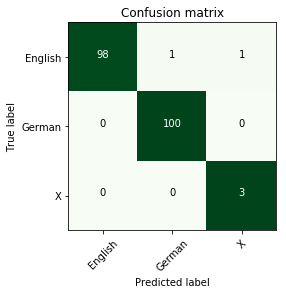

In [164]:
plot_confusion_matrix(cm, ['English', 'German', 'X'])